# Intra-Annual Sea Level Anomalies
![It's Moving!](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/plotly/SL_anomaly_map_pacific.gif)

In this notebook we'll take a look at monthly mean sea level anomalies. These monthly anamolies play a big part in Hawaii's sea level (and associated coastal flood warnings). For a nice graphic of daily anomalies, check out the [UHSLC Pacific Sea Level Monitoring](https://uhslc.soest.hawaii.edu/pacific-sea-level-monitoring/) page. There's a graphic of daily anomalies for the last 3 months or so, as well as a stationary plot of monthly anomalies across the Pacific basin. In this notebook, we'll focus on monthly mean anomalies solely in the Hawaiian Island region. 


## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. 

In [1]:
%run ../0_1_setup.ipynb
%pip install imageio # If you want to make the above animation, you'll need this package.

#import tseries functions
import sys, pathlib
sys.path.append(str(pathlib.Path('../../functions').resolve()))
import tseries_functions as tsf

Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output
Note: you may need to restart the kernel to use updated packages.


### Import the tide gauge data

In [2]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
# get percent Nans in rsl_daily['sea_level']

rsl_daily

<xarray.Dataset> Size: 1MB
Dimensions:       (station_id: 7, time: 11685)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
  * time          (time) datetime64[ns] 93kB 1993-01-02T12:00:00 ... 2024-12-...
    latitude      (station_id) float32 28B ...
    longitude     (station_id) float32 28B ...
    lat           (station_id) float64 56B ...
    lon           (station_id) float64 56B ...
    station_name  (station_id) <U27 756B ...
    storm_time    (time) datetime64[ns] 93kB ...
    compat        <U12 48B ...
Data variables:
    rsl_anomaly   (station_id, time) float64 654kB ...
    rsl_mhhw      (station_id, time) float64 654kB ...
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

### Check the data and drop all stations with less than 80% coverage

In [3]:
data_coverage = rsl_daily.rsl_mhhw.count(dim='time')/len(rsl_daily.time)

#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

rsl_subset

<xarray.Dataset> Size: 1MB
Dimensions:       (station_id: 7, time: 11685)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
  * time          (time) datetime64[ns] 93kB 1993-01-02T12:00:00 ... 2024-12-...
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    storm_time    (time) datetime64[ns] 93kB ...
    compat        <U12 48B 'no_conflicts'
Data variables:
    rsl_anomaly   (station_id, time) float64 654kB 0.1187 0.1158 ... 0.04415
    rsl_mhhw      (station_id, time) float64 654kB -0.2698 -0.2728 ... -0.2728
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [4]:
# get the record min and max for each TG by month
record_min = rsl_subset.groupby('time.month').min()
record_max = rsl_subset.groupby('time.month').max()

record_min

<xarray.Dataset> Size: 3kB
Dimensions:       (month: 12, station_id: 7)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    compat        <U12 48B 'no_conflicts'
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    rsl_anomaly   (month, station_id) float64 672B -0.1651 -0.1874 ... -0.1007
    rsl_mhhw      (month, station_id) float64 672B -0.5537 -0.3634 ... -0.4176
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [5]:
# select which station to plot
station_names = [str(name) for name in rsl_subset['station_name'].values]
station_ids = [str(sid) for sid in rsl_subset['station_id'].values]

#make a dict
station_dict = dict(zip(station_ids, station_names))
station_dict

{'1617760': 'Hilo, Hilo Bay, Kuhio Bay',
 '1619910': 'Sand Island, Midway Islands',
 '1617433': 'Kawaihae',
 '1612480': 'Mokuoloe',
 '1615680': 'Kahului, Kahului Harbor',
 '1612340': 'Honolulu',
 '1611400': 'Nawiliwili'}

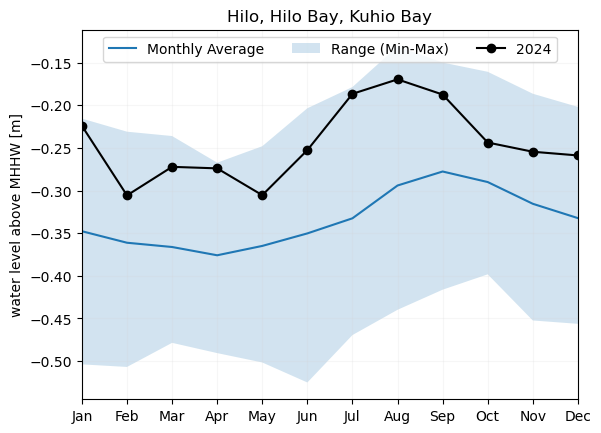

In [6]:
# Resample the data to get monthly means and squeeze any singleton dimensions
rsl_monthly = rsl_subset.resample(time='1MS').mean().squeeze()

# Calculate monthly statistics: mean, minimum, and maximum
epochStart = '1993-01-01'
epochEnd = '2024-12-31'
rsl_monthly_mean = rsl_monthly.sel(time=slice(epochStart, epochEnd)).groupby('time.month').mean()
rsl_monthly_min = rsl_monthly.sel(time=slice(epochStart, epochEnd)).groupby('time.month').min()
rsl_monthly_max = rsl_monthly.sel(time=slice(epochStart, epochEnd)).groupby('time.month').max()

station_id = station_ids[0]
station_name = station_dict[station_id]

# Plot the average sea level for each month
ax = rsl_monthly_mean['rsl_mhhw'].sel(station_id=station_id).plot(label='Monthly Average')


# Add shaded area between min and max values for each month
plt.fill_between(rsl_monthly_min.month, 
                 rsl_monthly_min['rsl_mhhw'].sel(station_id=station_id), 
                 rsl_monthly_max['rsl_mhhw'].sel(station_id=station_id), 
                 alpha=0.2, label='Range (Min-Max)')




# Add 2024 monthly values on top of the average
rsl_2024 = rsl_monthly.sel(time=slice('2024-01-01', '2024-12-31')).squeeze()
plt.plot(np.arange(1, 13), rsl_2024['rsl_mhhw'].sel(station_id=station_id).values, 
         color='black', label='2024', marker='o')

# Customize the x-axis to show month names instead of numbers
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Set labels and title
# plt.ylabel('Sea Level Anomaly (m)')
plt.xlabel('')
plt.title(rsl_monthly_mean['station_name'].sel(station_id=station_id).values)

# Adjust x-axis limits and add a grid
plt.xlim(1, 12)
# plt.ylim(-0.45, -0.05)
plt.grid(alpha=0.2, color='lightgray')

# Add a legend at the top in 3 columns
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1))

# Save the plot to a file
plt.savefig(output_dir / 'SL_MMMA_intra_pacific.png', dpi=300, bbox_inches='tight')

fig = plt.gcf()

glue("SL_MMA_intra",fig,display=False)
glue("station",station_name,display=False)
glue('epochEnd',epochEnd,display=False)
glue('epochStart',epochStart,display=False)


```{glue:figure} SL_MMA_intra
:name: "SL_MMA_intra"

Monthly means at the {glue:text}`station` tide gauge for {glue:text}`epochStart` to {glue:text}`epochEnd`. Note that the sea level is plotted in units of m, relative to MHHW. Note also that this differs from the plot available in the [UHSLC station explorer](https://uhslc.soest.hawaii.edu/stations/?stn=060#climatology), because we are using different periods of record. 
```

## Absolute Value: satellite (trend removed)

In [7]:
# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2025hawaii.nc')

#reduce to smaller area
cmems = cmems.sel(longitude=slice(180, 210), latitude=slice(15, 32))

### Plot an area-wide map, with stations
First we'll need to make sure that our data is detrended properly in order to look at monthly anomalies.

In [8]:
# remove long term trend from rsl using polynomial fit
trend_mag_cmems, trend_line_cmems, trend_rate_cmems = tsf.process_trend_with_nan(cmems.sla)

cmems_detrended = cmems.sla - trend_line_cmems

# make a cmems monthly mean for plotting
cmems_monthly = cmems_detrended.resample(time='1MS').mean().squeeze()

# get the mean for each month of the year (climatology)
cmems_climatology = cmems_monthly.groupby('time.month').mean(dim='time')

# get the anomaly by month (subtract the climatology from the monthly means))
cmems_mmsla = cmems_monthly.groupby('time.month') - cmems_climatology


Processing xarray DataArray (vectorized polyfit, time in years)...


Get the absolute sea level climatology at the tide gauge locations.

In [9]:
cmems_climatology_tg = cmems_climatology.interp(longitude=rsl_monthly.longitude, latitude=rsl_monthly.latitude, method='nearest')


In [10]:
cmems_climatology_tg

<xarray.DataArray (month: 12, station_id: 7)> Size: 672B
array([[ 0.00244534, -0.01351825,  0.00086107, -0.00880462, -0.00025437,
        -0.00770655, -0.00053864],
       [-0.01511243, -0.02057524, -0.02129247, -0.02143319, -0.01842723,
        -0.02124324, -0.02777314],
       [-0.02142161, -0.01850465, -0.0262841 , -0.02642605, -0.02621725,
        -0.0257167 , -0.04739772],
       [-0.03109388, -0.01744216, -0.03317708, -0.02350258, -0.02214491,
        -0.0222558 , -0.03480317],
       [-0.01948418, -0.01319266, -0.02274411, -0.02336964, -0.02437358,
        -0.02330154, -0.02593042],
       [-0.01171713, -0.0230502 , -0.00816921, -0.00599296, -0.00925053,
        -0.00637762, -0.0085661 ],
       [-0.0100638 , -0.00752112, -0.00569407, -0.00119578, -0.00166757,
        -0.00092997,  0.01942656],
       [ 0.0182399 ,  0.02334065,  0.02134228,  0.01843451,  0.02059519,
         0.01910118,  0.02191002],
       [ 0.02903066,  0.04020436,  0.03003742,  0.03277401,  0.03352835,
         0.03166846,  0.03640273],
       [ 0.0266508 ,  0.02786007,  0.0252148 ,  0.02890918,  0.02647066,
         0.02906176,  0.03938595],
       [ 0.01918799,  0.01325328,  0.0224444 ,  0.02263314,  0.01823743,
         0.02155267,  0.02450931],
       [ 0.01414104,  0.00982779,  0.01831988,  0.00914997,  0.00449553,
         0.00720904,  0.00471199]])
Coordinates:
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    compat        <U12 48B 'no_conflicts'

Text(0.02, 0.5, 'Monthly Mean Sea Level Anomaly [m]')

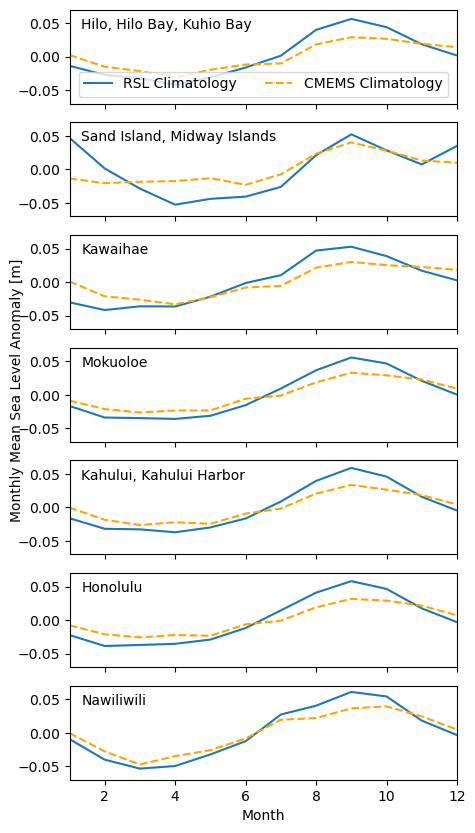

In [11]:
#compare cmems_climatology_tg with rsl_monthly_mean
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(5, 10), sharex=True, sharey=True)
axes = axes.flatten()
# iterate over each axis and plot the monthly mean
for i in range(len(station_ids)):
    ax = axes[i]
    (rsl_monthly_mean['rsl_anomaly'].sel(station_id=station_ids[i])- rsl_monthly_mean['rsl_anomaly'].sel(station_id=station_ids[i]).mean()).plot(ax = ax, x='month',label='RSL Climatology')
    # Add cmems climatology at the station location
    cmems_climatology_tg.sel(station_id=station_ids[i]).plot.line(ax=ax, x='month', label='CMEMS Climatology', color='orange', linestyle='--')

    ax.set_ylim([-0.07,0.07])
    ax.set_xlim([1,12])

    ax.text(0.03,0.8,rsl_monthly['station_name'].values[i], fontsize=10,transform=ax.transAxes)
    ax.set_ylabel(None)
    ax.set_title(None)
    ax.set_xlabel(None)

    if i == 0:
        ax.legend(loc='lower center', ncol=3)   


# add a common x and y label
axes[-1].set_xlabel('Month')
fig.text(0.02, 0.5, 'Monthly Mean Sea Level Anomaly [m]', ha='center', va='center', rotation='vertical')

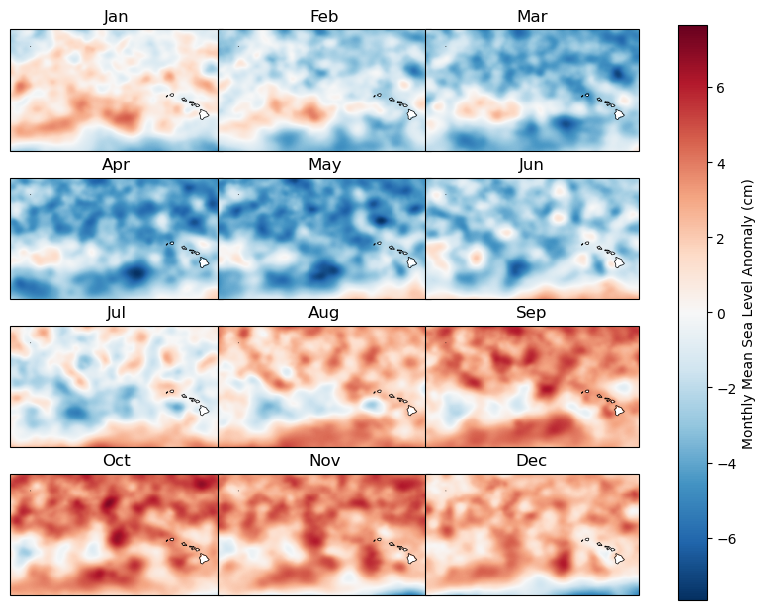

In [12]:
# plot the monthly_anomalies*100 for centimeters
cmems_cm = cmems_climatology * 100



# convert cmems_cm.month to datetime object
months = pd.to_datetime(cmems_cm.month.values, format='%m').strftime('%b')


# Plot the data with modified titles
mma = cmems_cm.plot(transform=ccrs.PlateCarree(), col='month', col_wrap=3,
                        aspect=cmems_cm.sizes['longitude'] / cmems_cm.sizes['latitude'],
                        subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)},)

# Add coastlines and land features to each subplot
for i,ax in enumerate(mma.axs.flat):
    ax.coastlines(linewidth=0.5)
    ax.set_title(months[i])
    ax.set_extent([180, 207,  15, 30]) 

# change the colorbar label
mma.cbar.set_label('Monthly Mean Sea Level Anomaly (cm)')  

#assign mma to a figure
fig = plt.gcf()

# change figure size
fig.set_size_inches(8, 6)

#save the figure
fig.savefig(output_dir / 'SL_anomaly_map_pacific.png', dpi=300)

glue("mma_asl_fig", fig, display=False)



```{glue:figure} mma_asl_fig
:name: "mma-asl-fig"
Map of absolute monthly mean sea level anomalies from altimetry for the full record from {glue:text}`station_group`, {glue:text}`country` station from {glue:text}`epochStart` to {glue:text}`epochEnd`. This plot is our monthly climatology - sea levels in Hawaii are on average lower in the spring (March-May) and higher in the fall (September-November). 
```


In [13]:
# we can also plot any given year against the climatology
year = '2023'
yearStart = f'{year}-01-01'
yearEnd = f'{year}-12-31'

cmems_Year = cmems_mmsla.sel(time=slice(yearStart, yearEnd)).squeeze()
# get monthly means
cmems_Year_monthly = cmems_Year.groupby('time.month').mean(dim='time')

cmems_Year_monthly_anomaly = cmems_Year_monthly - cmems_climatology
# plot the monthly_anomalies*100 for centimeters
cmems_Year_cm = cmems_Year_monthly_anomaly * 100


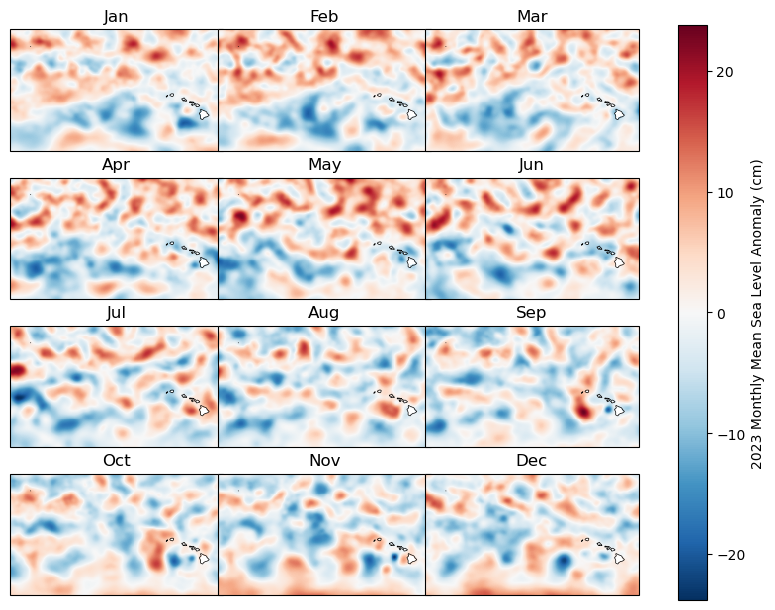

In [14]:
# Plot the data with modified titles
mma = cmems_Year_cm.plot(transform=ccrs.PlateCarree(), col='month', col_wrap=3,
                        aspect=cmems_Year_cm.sizes['longitude'] / cmems_Year_cm.sizes['latitude'],
                        subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)},)

# Add coastlines and land features to each subplot
for i,ax in enumerate(mma.axs.flat):
    ax.coastlines(linewidth=0.5)
    ax.set_title(months[i])
    ax.set_extent([180, 207,  15, 30]) 

# change the colorbar label
mma.cbar.set_label(f'{year} Monthly Mean Sea Level Anomaly (cm)')  

#assign mma to a figure
fig = plt.gcf()

# change figure size
fig.set_size_inches(8, 6)

Let's try that in a movie.

In [15]:
import imageio.v2 as imageio

frames = []
for i, month in enumerate(months):
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(6,3))
    cmems_Year_cm.sel(month=i+1).plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-25, vmax=25, cmap='RdBu_r', cbar_kwargs={'label': f'{year} Monthly Mean \nSea Level Anomaly (cm)'})
    ax.coastlines(linewidth=0.5)
    ax.set_title(month)
    ax.set_extent([180, 207, 15, 30])
    # Save each month as a PNG
    fname = output_dir / f"SL_anomaly_map_pacific_{month}.png"
    fig.savefig(fname, dpi=150)
    frames.append(str(fname))
    plt.close(fig)

# Create GIF from saved PNGs
images = [imageio.imread(frame) for frame in frames]
gif_path = output_dir / "SL_anomaly_map_pacific.gif"
imageio.mimsave(gif_path, images, fps=3, loop=0)


![It's Moving!](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/plotly/SL_anomaly_map_pacific.gif)

## Relative Value: tide station (trend removed)
### area-wide map with stations
### station plots: time series  
These should have ONI/ENSO phase included on them

In [16]:
rsl_monthly

<xarray.Dataset> Size: 47kB
Dimensions:       (time: 384, station_id: 7)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    compat        <U12 48B 'no_conflicts'
  * time          (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-12-01
Data variables:
    rsl_anomaly   (time, station_id) float64 22kB 0.02924 -0.00364 ... 0.1133
    rsl_mhhw      (time, station_id) float64 22kB -0.3593 -0.1796 ... -0.2036
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [17]:
# remove long-term trend from rsl_monthly
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = tsf.process_trend_with_nan(rsl_monthly.rsl_anomaly)

rsl_monthly_detrended = rsl_monthly.rsl_anomaly - trend_line_rsl

# add detrended rsl_monthly to rsl_monthly
rsl_monthly['sea_level_detrended'] = rsl_monthly_detrended
rsl_monthly['sea_level_detrended'].attrs = {'long_name': 'sea level anomaly', 'units': 'm'}

Processing xarray DataArray (vectorized polyfit, time in years)...


In [18]:
# remove annual cycle from rsl_monthly
rsl_monthly_detrended = rsl_monthly_detrended.groupby('time.month') - rsl_monthly_detrended.groupby('time.month').mean(dim='time')

# add to rsl_monthly
rsl_monthly['sea_level_detrended_anom'] = rsl_monthly_detrended
rsl_monthly['sea_level_detrended_anom'].attrs = {'long_name': 'monthly mean sea level anomaly', 'units': 'm'}

## Make a plot

In [19]:
rsl_monthly.sel(station_id=station_id)

<xarray.Dataset> Size: 22kB
Dimensions:                   (time: 384)
Coordinates:
    station_id                <U7 28B '1617760'
    latitude                  float32 4B 19.69
    longitude                 float32 4B 204.9
    lat                       float64 8B 19.73
    lon                       float64 8B 204.9
    station_name              <U27 108B 'Hilo, Hilo Bay, Kuhio Bay'
    compat                    <U12 48B 'no_conflicts'
  * time                      (time) datetime64[ns] 3kB 1993-01-01 ... 2024-1...
    time_in_years             (time) float64 3kB 1.993e+03 ... 2.025e+03
    month                     (time) int64 3kB 1 2 3 4 5 6 7 ... 7 8 9 10 11 12
Data variables:
    rsl_anomaly               (time) float64 3kB 0.02924 0.01537 ... 0.1296
    rsl_mhhw                  (time) float64 3kB -0.3593 -0.3732 ... -0.2589
    sea_level_detrended       (time) float64 3kB 0.03315 0.01897 ... 0.01644
    sea_level_detrended_anom  (time) float64 3kB 0.0448 0.04442 ... 0.0166
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

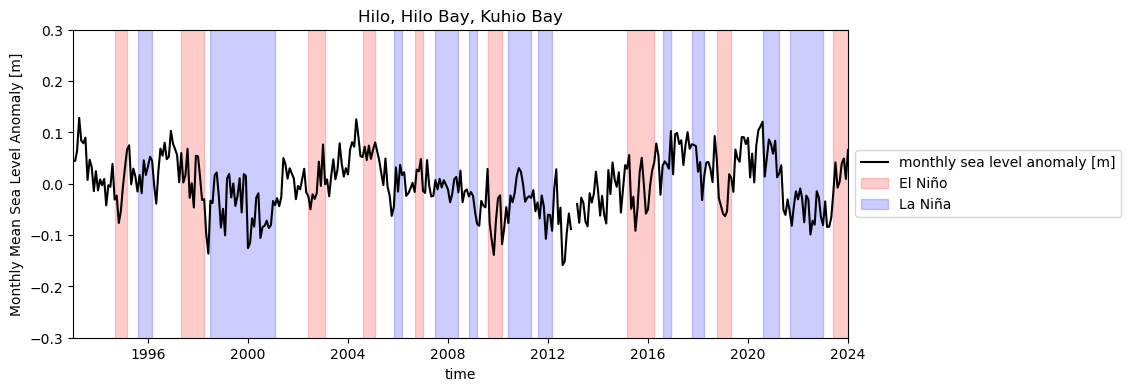

In [20]:
# get axis for the plots
fig,ax = plt.subplots(1,1,figsize=(10,4), sharex=True, sharey=True)

# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'climate_indices'/'oni_bool.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['time'] )



rsl_monthly['sea_level_detrended_anom'].sel(station_id=station_id).plot.line(ax=ax, x='time', label='monthly sea level anomaly [m]', color='black')
# Shading El Niño events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')
# Shading La Niña events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')

ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
ax.set_ylim([-0.3,0.3])
ax.set_title(rsl_monthly['station_name'].sel(station_id=station_id).values)
ax.set_ylabel('Monthly Mean Sea Level Anomaly [m]')

 #put legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#save the figure
# fig.savefig(output_dir / 'SL_anomaly_timseries_pacific.png', dpi=300)
# glue("SL_anomaly_timeseries_honolulu_fig", fig, display=False)

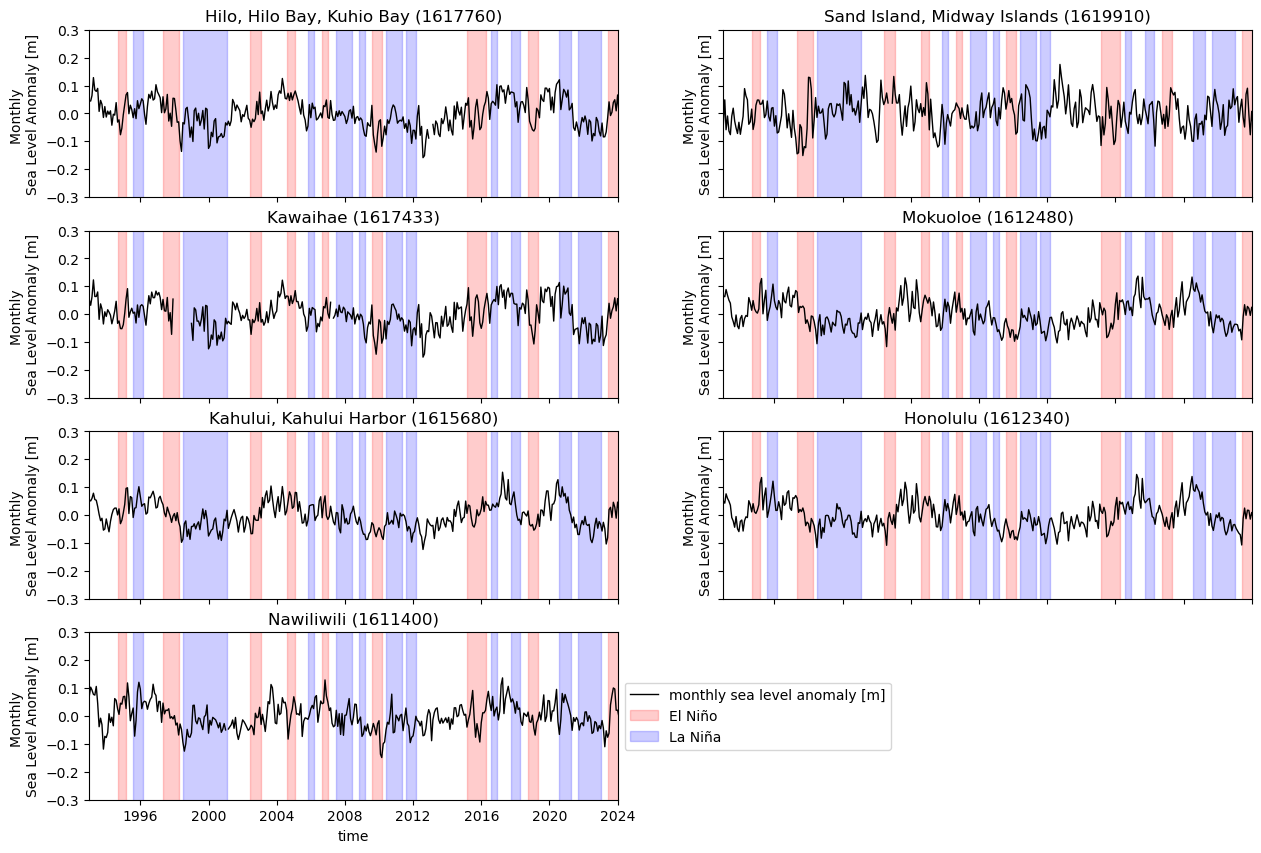

In [21]:

# get axis for the plots
fig,axes = plt.subplots(4,2,figsize=(15,10), sharex=True, sharey=True)
axes = axes.flatten()

# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'climate_indices'/'oni_bool.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['time'] )


# iterate over each axis and plot the monthly mean
for i in range(len(station_ids)):
    ax = axes[i]
    rsl_monthly['sea_level_detrended_anom'].sel(station_id=station_ids[i]).plot.line(ax=ax, x='time', label='monthly sea level anomaly [m]', color='black',linewidth=1)

    # Shading El Niño events
    ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                    where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')

    # Shading La Niña events
    ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                    where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')
    
    ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
    ax.set_ylim([-0.3,0.3])

    ax.set_title(rsl_monthly['station_name'].values[i] + f' ({station_ids[i]})')
    ax.set_ylabel('Monthly \nSea Level Anomaly [m]')

    if i < 6:
        ax.set_xlabel('')

# remove empty subplots
for i in range(len(station_ids), len(axes)):
    fig.delaxes(axes[i])

#put legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#save the figure
fig.savefig(output_dir / 'SL_anomaly_timeseries_stations.png', dpi=300)

glue("SL_anomaly_timeseries_stations_fig", fig, display=False)


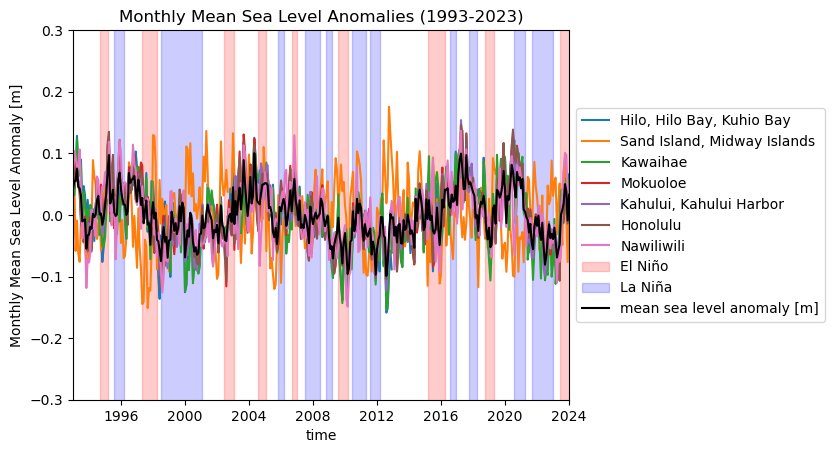

In [22]:
# make the same plot but only on one axis
fig,ax = plt.subplots()


rsl_monthly['sea_level_detrended_anom'].plot.line(x='time', label=rsl_monthly['station_name'].values)

# add ONI shading
# Shading El Niño events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')

# Shading La Niña events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')

ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
ax.set_ylim([-0.3,0.3])

#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# add mean sea level anomaly to the plot
rsl_monthly['sea_level_detrended_anom'].mean(dim='station_id').plot.line(x='time', label='mean sea level anomaly [m]', color='black')

#update the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# change ylabel
ax.set_ylabel('Monthly Mean Sea Level Anomaly [m]')
ax.set_title('Monthly Mean Sea Level Anomalies (1993-2023)')


#save the figure
fig.savefig(output_dir / 'SL_anomaly_timeseries.png', dpi=300)

glue("SL_anomaly_timeseries_fig", fig, display=False)


```{glue:figure} SL_anomaly_timeseries_fig
:name: "SL_anomaly_timeseries"
Plot of absolute monthly mean sea level anomalies from tide gauges for the full record from the Hawaiian Island region stations, station from {glue:text}`epochStart` to {glue:text}`epochEnd`.
```
